<a href="https://colab.research.google.com/github/tiarmdhnt/Song-Popularity-Prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import and Libraries**

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# **Preprocessing**

In [2]:
data = pd.read_csv('spotify.csv', encoding='latin-1')

In [3]:
# Drop unnecessary columns
columns_to_drop = [
    'track_name', 'key', 'artist(s)_name', 'artist_count', 'released_year',
    'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts',
    'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
    'in_deezer_charts', 'in_shazam_charts'
]
df = data.drop(columns=columns_to_drop)

In [4]:
# Map categorical data
df['mode'] = df['mode'].map({'Major': 1, 'Minor': 0})

# Handle missing values in 'streams'
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df.dropna(subset=['streams'], inplace=True)

# Convert streams to integer
df['streams'] = df['streams'].astype(int)

# Discretize 'streams' using conditions
column_to_modify = 'streams'
condition_1 = df[column_to_modify].between(0, 3703895074 / 4)
condition_2 = df[column_to_modify].between(3703895074 / 4, 3703895074 / 4 * 2)
condition_3 = df[column_to_modify].between(3703895074 / 4 * 2, 3703895074 / 4 * 3)
condition_4 = df[column_to_modify].between(3703895074 / 4 * 3, 3703895074)

df['streams'] = np.where(
    condition_1, -1,
    np.where(
        condition_2, 0,
        np.where(condition_3, 1, np.where(condition_4, 2, df[column_to_modify]))
    )
)

In [5]:
print(df.head())

   streams  bpm  mode  danceability_%  valence_%  energy_%  acousticness_%  \
0       -1  125     1              80         89        83              31   
1       -1   92     1              71         61        74               7   
2       -1  138     1              51         32        53              17   
3       -1  170     1              55         58        72              11   
4       -1  144     0              65         23        80              14   

   instrumentalness_%  liveness_%  speechiness_%  
0                   0           8              4  
1                   0          10              4  
2                   0          31              6  
3                   0          11             15  
4                  63          11              6  


In [6]:
# Normalize features
X = minmax_scale(df.drop('streams', axis=1).values)

# One-hot encode target
def onehot_enc(lbl):
    return np.eye(len(set(lbl)))[lbl.astype(int)]

Y = onehot_enc(df['streams'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)


# **Activation and Utility Functions**

In [7]:
# Sigmoid and its derivative
def sig(x):
    return 1 / (1 + np.exp(-x))

def sigd(x):
    return sig(x) * (1 - sig(x))

# Tanh and its derivative
def tanh(x):
    return np.tanh(x)

def tanhd(x):
    return 1 - np.tanh(x)**2

# One-hot decode
def onehot_dec(enc):
    return [np.argmax(e) for e in enc]

# **Backpropagation Training Function**

In [13]:
def bp_fit_sig(X, target, layer_conf, max_epoch, max_error=.1, learn_rate=.1, print_per_epoch=100):
    start_time = time.time()
    np.random.seed(1)

    # Initialize layers, weights, and deltas
    nin = [np.empty(i) for i in layer_conf]
    n = [np.empty(j + 1) if i < len(layer_conf) - 1 else np.empty(j) for i, j in enumerate(layer_conf)]
    w = [np.random.rand(layer_conf[i] + 1, layer_conf[i + 1]) for i in range(len(layer_conf) - 1)]
    dw = [np.empty((layer_conf[i] + 1, layer_conf[i + 1])) for i in range(len(layer_conf) - 1)]
    d = [np.empty(s) for s in layer_conf[1:]]
    din = [np.empty(s) for s in layer_conf[1:-1]]

    epoch = 0
    mse = 1

    # Set bias neurons
    for i in range(0, len(n) - 1):
        n[i][-1] = 1

    # Training loop
    while (max_epoch == -1 or epoch < max_epoch) and mse > max_error:
        epoch += 1
        mse = 0
        for r in range(len(X)):
            # Forward pass
            n[0][:-1] = X[r]
            for L in range(1, len(layer_conf)):
                nin[L] = np.dot(n[L - 1], w[L - 1])
                n[L][:len(nin[L])] = sig(nin[L])

            # Calculate error and backpropagate
            e = target[r] - n[-1]
            mse += sum(e ** 2)
            d[-1] = e * sigd(nin[-1])
            dw[-1] = learn_rate * d[-1] * n[-2].reshape((-1, 1))
            for L in range(len(layer_conf) - 1, 1, -1):
                din[L - 2] = np.dot(d[L - 1], np.transpose(w[L - 1][:-1]))
                d[L - 2] = din[L - 2] * np.array(sigd(nin[L - 1]))
                dw[L - 2] = (learn_rate * d[L - 2]) * n[L - 2].reshape((-1, 1))
            w = [w[L] + dw[L] for L in range(len(w))]

        # Calculate mean squared error
        mse /= len(X)
        if print_per_epoch > -1 and epoch % print_per_epoch == 0:
            print(f'Epoch {epoch}, MSE: {mse}')

    execution = time.time() - start_time
    print("Waktu eksekusi: %s detik" % execution)
    return w, epoch, mse


In [21]:
def bp_fit_tanh(X, target, layer_conf, max_epoch, max_error=.1, learn_rate=.1, print_per_epoch=100):
    start_time = time.time()
    np.random.seed(1)

    # Initialize layers, weights, and deltas
    nin = [np.empty(i) for i in layer_conf]
    n = [np.empty(j + 1) if i < len(layer_conf) - 1 else np.empty(j) for i, j in enumerate(layer_conf)]
    w = [np.random.rand(layer_conf[i] + 1, layer_conf[i + 1]) for i in range(len(layer_conf) - 1)]
    dw = [np.empty((layer_conf[i] + 1, layer_conf[i + 1])) for i in range(len(layer_conf) - 1)]
    d = [np.empty(s) for s in layer_conf[1:]]
    din = [np.empty(s) for s in layer_conf[1:-1]]

    epoch = 0
    mse = 1

    # Set bias neurons
    for i in range(0, len(n) - 1):
        n[i][-1] = 1

    # Training loop
    while (max_epoch == -1 or epoch < max_epoch) and mse > max_error:
        epoch += 1
        mse = 0
        for r in range(len(X)):
            # Forward pass
            n[0][:-1] = X[r]
            for L in range(1, len(layer_conf)):
                nin[L] = np.dot(n[L - 1], w[L - 1])
                n[L][:len(nin[L])] = tanh(nin[L])

            # Calculate error and backpropagate
            e = target[r] - n[-1]
            mse += sum(e ** 2)
            d[-1] = e * tanhd(nin[-1])
            dw[-1] = learn_rate * d[-1] * n[-2].reshape((-1, 1))
            for L in range(len(layer_conf) - 1, 1, -1):
                din[L - 2] = np.dot(d[L - 1], np.transpose(w[L - 1][:-1]))
                d[L - 2] = din[L - 2] * np.array(tanhd(nin[L - 1]))
                dw[L - 2] = (learn_rate * d[L - 2]) * n[L - 2].reshape((-1, 1))
            w = [w[L] + dw[L] for L in range(len(w))]

        # Calculate mean squared error
        mse /= len(X)
        if print_per_epoch > -1 and epoch % print_per_epoch == 0:
            print(f'Epoch {epoch}, MSE: {mse}')

    execution = time.time() - start_time
    print("Waktu eksekusi: %s detik" % execution)
    return w, epoch, mse

# **Prediction Function**

In [22]:
def bp_predict_sig(X, w):
  n = [np.empty(len(i)) for i in w]
  nin = [np.empty(len(i[0])) for i in w]
  predict = []
  n.append(np.empty(len(w[-1][0])))
  for x in X:
    n[0][:-1] = x
    for L in range(0, len(w)):
      nin[L] = np.dot(n[L], w[L])
      n[L + 1][:len(nin[L])] = sig(nin[L])
    predict.append(n[-1].copy())
  return predict

In [23]:
#Membuat fungsi testing backpropagation dengan menggunakan fungsi aktivasi tanh
def bp_predict_tanh(X, w):
  n = [np.empty(len(i)) for i in w]
  nin = [np.empty(len(i[0])) for i in w]
  predict = []
  n.append(np.empty(len(w[-1][0])))
  for x in X:
    n[0][:-1] = x
    for L in range(0, len(w)):
      nin[L] = np.dot(n[L], w[L])
      n[L + 1][:len(nin[L])] = tanh(nin[L])
    predict.append(n[-1].copy())
  return predict

# **Training and Testing**

In [17]:
X = minmax_scale(df.drop('streams', axis=1).values)
Y = onehot_enc(df['streams'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

w, ep, mse = bp_fit_sig(X_train, y_train, layer_conf=(9, 5, 4), learn_rate=0.1, max_epoch=1000, max_error=0.1, print_per_epoch=25)

print(f'Epochs: {ep}, MSE: {mse}')

predict = bp_predict_sig(X_test, w)

predict = onehot_dec(predict)
y_test = onehot_dec(y_test)

accuracy = accuracy_score(predict, y_test)

print('Output:', predict)
print('True :', y_test)
print('Accuracy:', accuracy)

Epoch 25, MSE: 0.30726756427856516
Epoch 50, MSE: 0.3047075104129899
Epoch 75, MSE: 0.3029776156679167
Epoch 100, MSE: 0.3022052180051458
Epoch 125, MSE: 0.30180821833517396
Epoch 150, MSE: 0.30153331202702605
Epoch 175, MSE: 0.3013131060586739
Epoch 200, MSE: 0.30112273628483255
Epoch 225, MSE: 0.3009514307752929
Epoch 250, MSE: 0.3007939932918873
Epoch 275, MSE: 0.3006474154893928
Epoch 300, MSE: 0.3005094685347082
Epoch 325, MSE: 0.3003780752047796
Epoch 350, MSE: 0.3002510429049919
Epoch 375, MSE: 0.30012597158700816
Epoch 400, MSE: 0.30000021065633053
Epoch 425, MSE: 0.2998707870544469
Epoch 450, MSE: 0.29973427968626565
Epoch 475, MSE: 0.29958665685796276
Epoch 500, MSE: 0.2994231239460176
Epoch 525, MSE: 0.2992380628200792
Epoch 550, MSE: 0.29902519516498194
Epoch 575, MSE: 0.29877815989366346
Epoch 600, MSE: 0.2984917021464903
Epoch 625, MSE: 0.2981635056572917
Epoch 650, MSE: 0.29779625142747473
Epoch 675, MSE: 0.2973988877775124
Epoch 700, MSE: 0.2969859112832772
Epoch 725, M

In [24]:
X = minmax_scale(df.drop('streams', axis=1).values)
Y = onehot_enc(df['streams'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=1)
w, ep, mse = bp_fit_tanh(X_train, y_train, layer_conf=(9, 5, 4), learn_rate=0.1, max_epoch=1000, max_error=0.1, print_per_epoch=25)

print(f'Epochs: {ep}, MSE: {mse}')

predict = bp_predict_tanh(X_test, w)
predict = onehot_dec(predict)
y_test = onehot_dec(y_test)
accuracy = accuracy_score(predict, y_test)

print('Output:', predict)
print('True :', y_test)
print('Accuracy:', accuracy)

Epoch 25, MSE: 0.3156048677184716
Epoch 50, MSE: 0.31516441872131357
Epoch 75, MSE: 0.3151134879781533
Epoch 100, MSE: 0.31507327456145906
Epoch 125, MSE: 0.3150052795501799
Epoch 150, MSE: 0.3149232484800061
Epoch 175, MSE: 0.3148613290372724
Epoch 200, MSE: 0.31483604423065464
Epoch 225, MSE: 0.3148208073397469
Epoch 250, MSE: 0.31477926158350605
Epoch 275, MSE: 0.31471044249732233
Epoch 300, MSE: 0.3146306451842738
Epoch 325, MSE: 0.31455556620448655
Epoch 350, MSE: 0.3145025420934547
Epoch 375, MSE: 0.3144771165876367
Epoch 400, MSE: 0.31447348471382097
Epoch 425, MSE: 0.3144863335483584
Epoch 450, MSE: 0.3145109869676936
Epoch 475, MSE: 0.31454019036737696
Epoch 500, MSE: 0.314564596566064
Epoch 525, MSE: 0.3145736128869583
Epoch 550, MSE: 0.3145600893635945
Epoch 575, MSE: 0.3145272703415796
Epoch 600, MSE: 0.3144879914951857
Epoch 625, MSE: 0.31445627853612246
Epoch 650, MSE: 0.3144374888212427
Epoch 675, MSE: 0.314427401322614
Epoch 700, MSE: 0.3144217127913276
Epoch 725, MSE: 

# **Visualization**

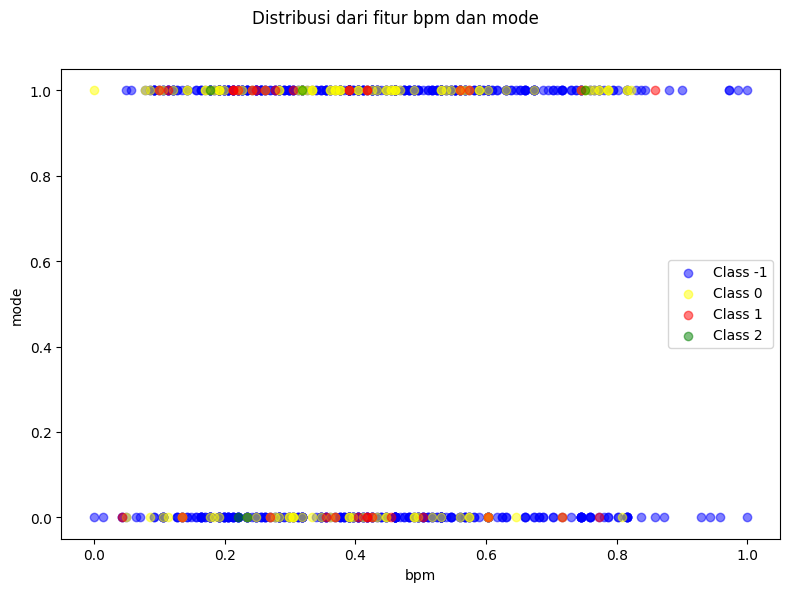

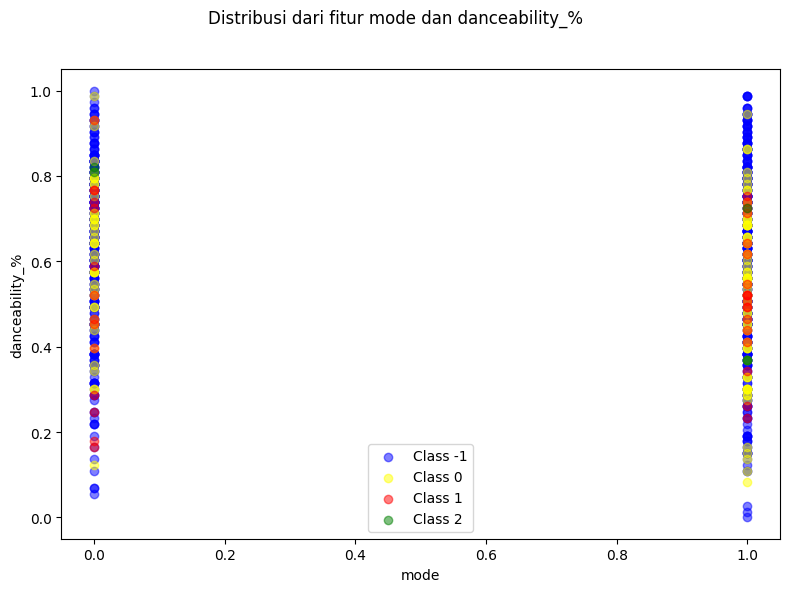

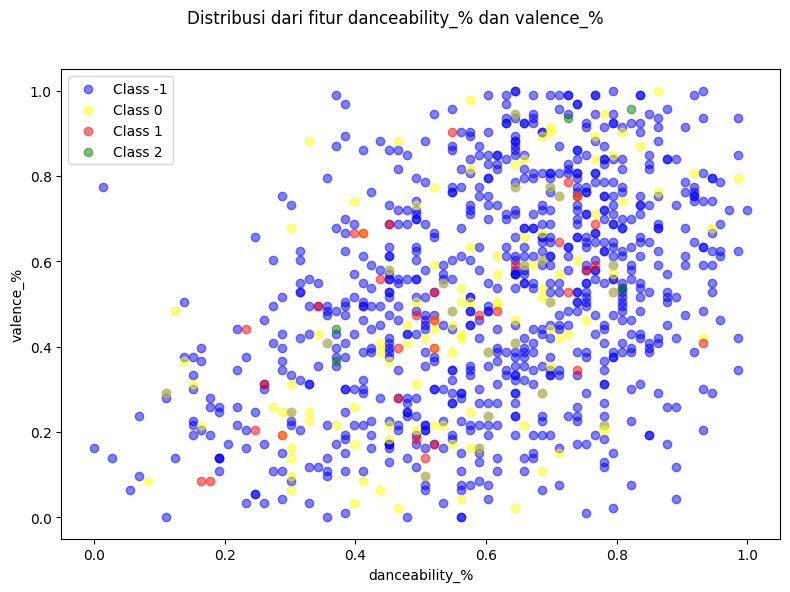

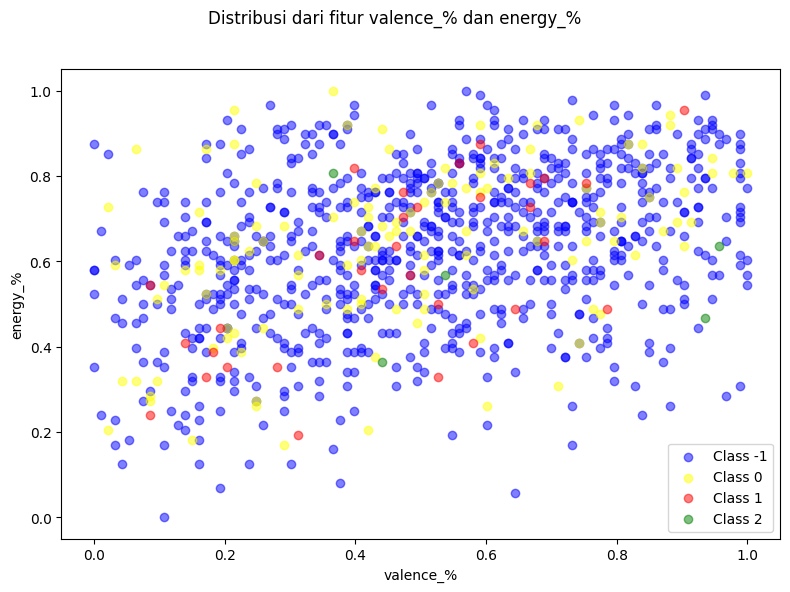

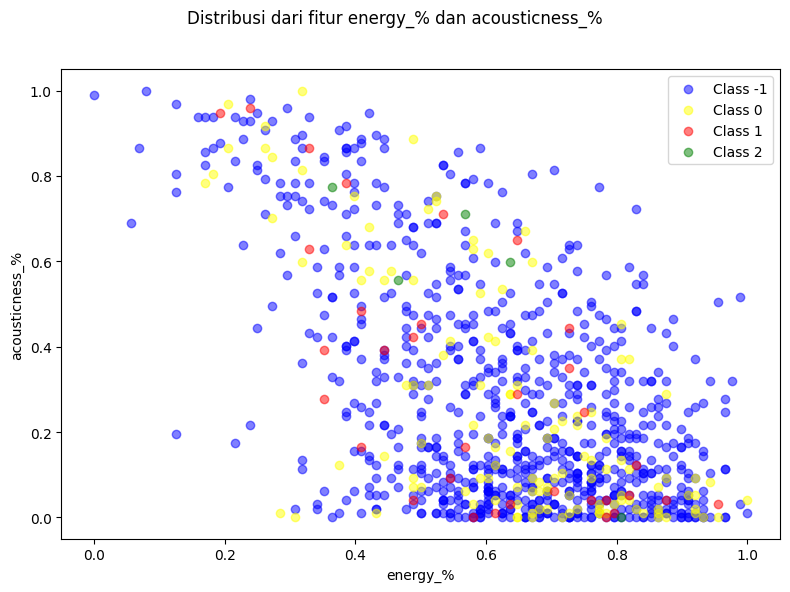

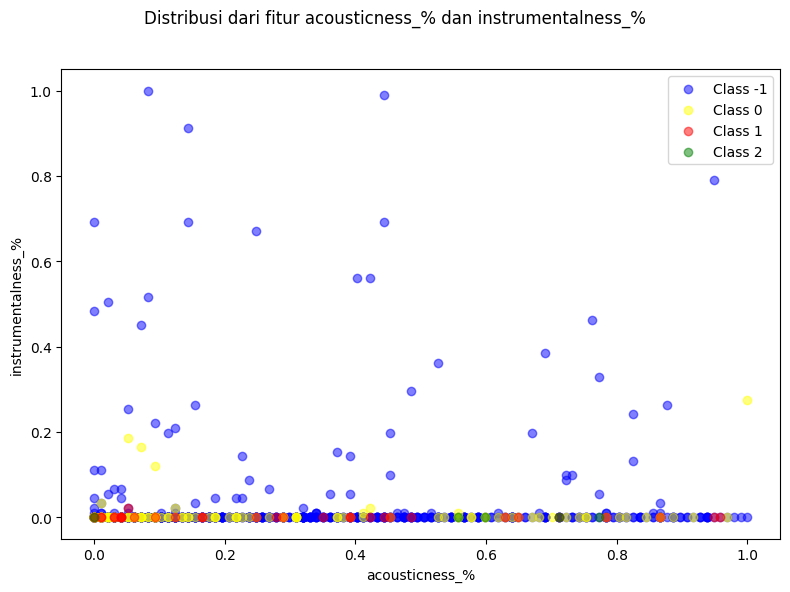

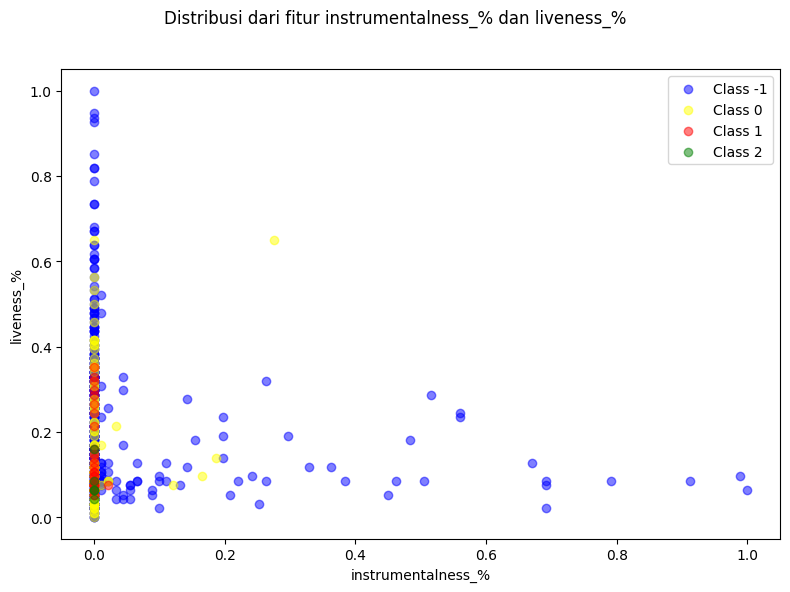

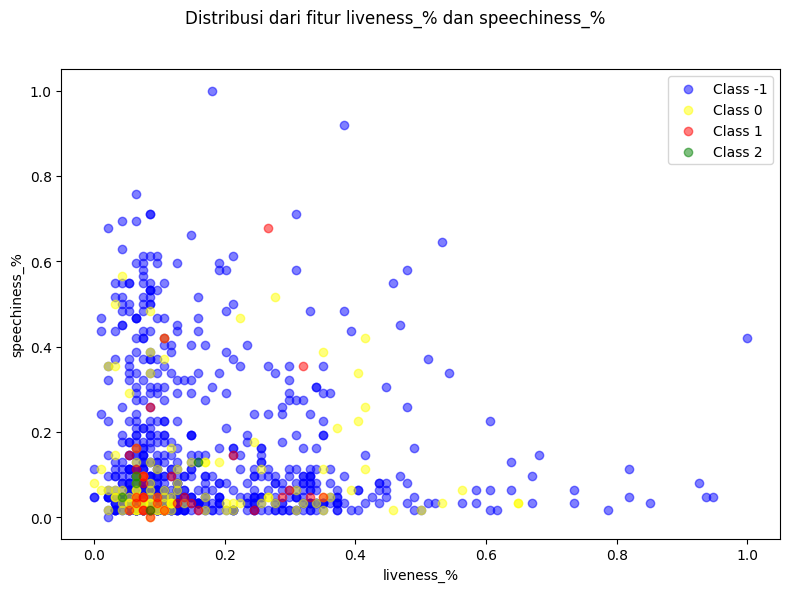

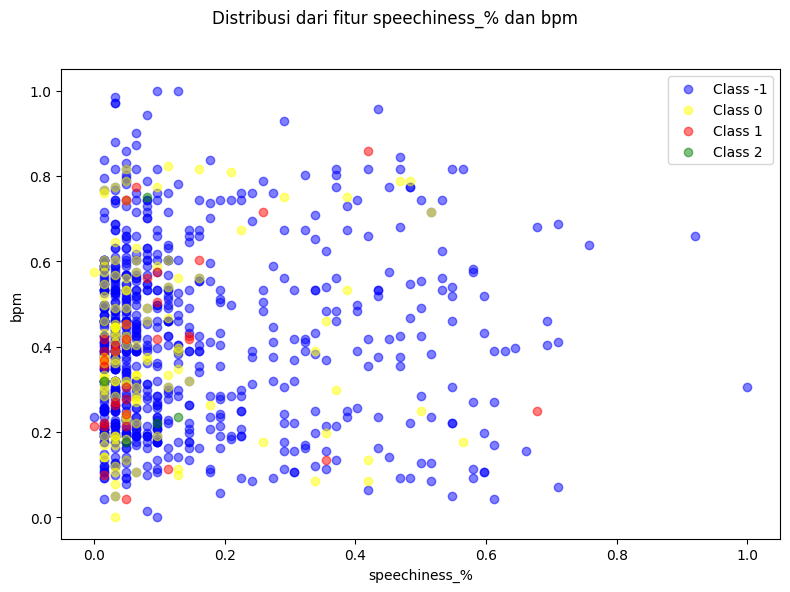

In [25]:
X = minmax_scale(df.drop('streams', axis=1).values)
Y = onehot_enc(df['streams'])

class_colors = {-1: 'blue', 0: 'yellow', 1: 'red', 2: 'green'}

output_classes = df['streams'].unique()
feature_names = df.drop('streams', axis=1).columns

feature_pairs = [(i, i + 1) for i in range(8)] + [(8, 0)]

for pair in feature_pairs:
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle(f'Distribusi dari fitur {feature_names[pair[0]]} dan {feature_names[pair[1]]}')

    for output_class in output_classes:
        indices = df['streams'] == output_class
        ax.scatter(X[indices, pair[0]], X[indices, pair[1]], label=f'Class {output_class}', color=class_colors[output_class], alpha=0.5)

    ax.set_xlabel(f'{feature_names[pair[0]]}')
    ax.set_ylabel(f'{feature_names[pair[1]]}')
    ax.legend()

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()